In [ ]:
# ARIMA Analysis

Text(0.5, 1.0, 'Sales for All Items')

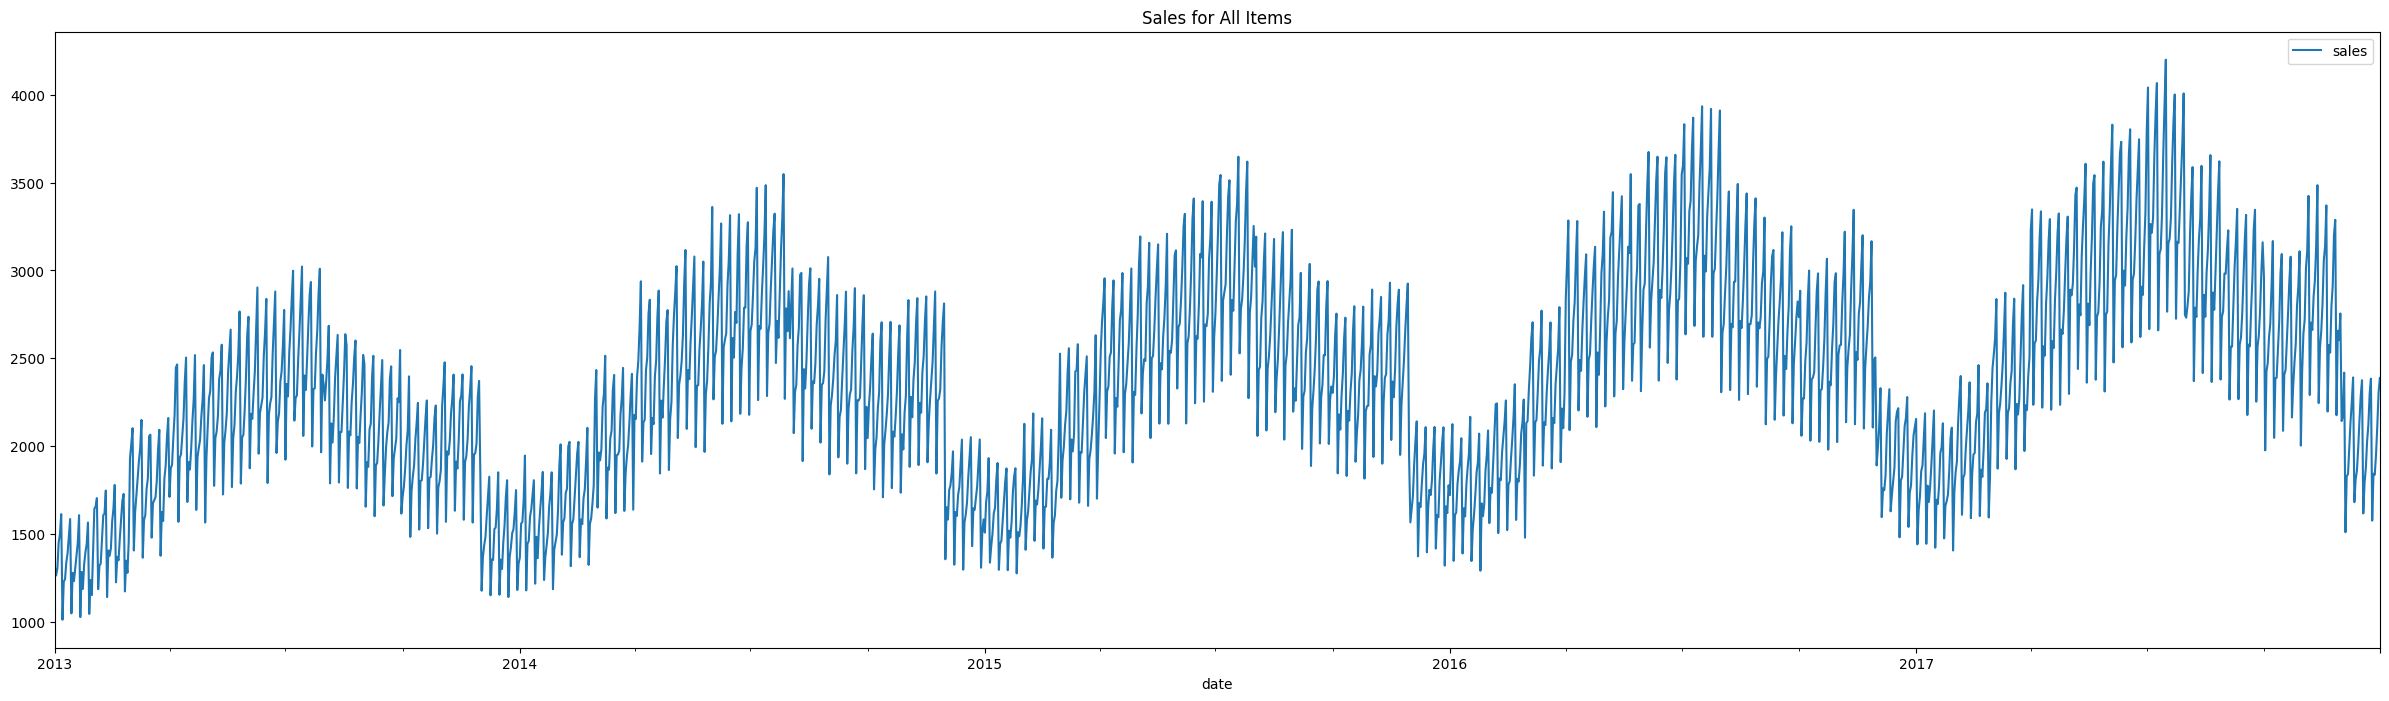

In [505]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

df = pd.read_csv('train.csv')
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')



# Use only data from store
trim = df[df['store'] == 1]
# trim = trim.drop('store', axis =1)
# trim = trim.drop('item', axis = 1)

sum = trim.groupby(['date'])['sales'].sum().reset_index()
sum.set_index('date',inplace=True)

fig = sum[['sales']].plot(figsize=(30,8))
fig.set_title("Sales for All Items")


## Check p value

In [ ]:
from statsmodels.tsa.stattools import adfuller

def adfuller_test(sales):
    result=adfuller(sales)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("valid p-value")
    else:
        print("invalid p-value")


adfuller_test(sum['sales'])

ADF Test Statistic : -2.984076999120178
p-value : 0.03640840305195679
#Lags Used : 22
Number of Observations Used : 1803
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


In [507]:
sum['Sale First Difference'] = sum['sales'] - sum['sales'].shift(1)
sum['Seasonal First Difference'] = sum['sales'] - sum['sales'].shift(12)

adfuller_test(sum['Seasonal First Difference'].dropna())

ADF Test Statistic : -4.756995611102794
p-value : 6.568057771917002e-05
#Lags Used : 25
Number of Observations Used : 1788
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


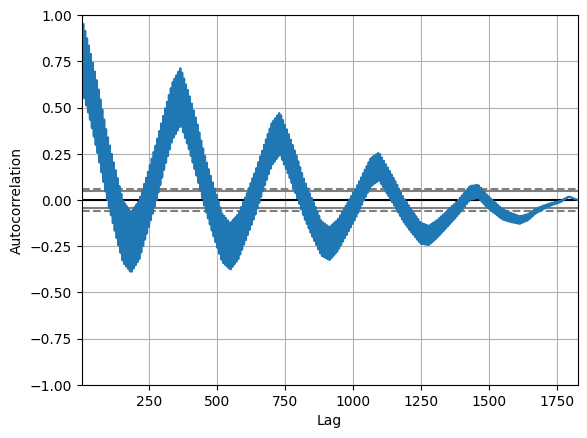

In [509]:
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(sum['sales'])
plt.show()

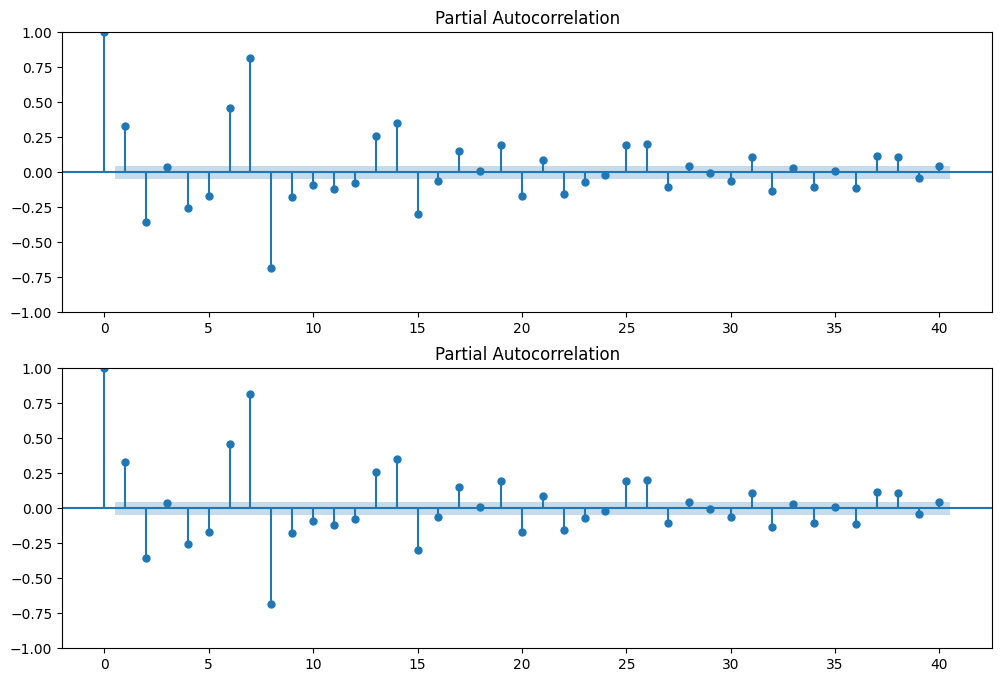

In [510]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_pacf(sum['Seasonal First Difference'].iloc[13:], lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(sum['Seasonal First Difference'].iloc[13:], lags=40, ax=ax2)


In [ ]:
## Train with ARIMA

In [511]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(sum['sales'], order=(3,1,2))
model_fit = model.fit()
model_fit.summary()


from sklearn.metrics import mean_squared_error, r2_score

sum['forecast'] = model_fit.predict()

sales = sum['sales']
forecast = sum['forecast']

mse = mean_squared_error(sales, forecast)
r2 = r2_score(sales, forecast)
print(mse)
print (r2)



/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


79067.96681502151
0.767383661092405


r2_Score:  0.767383661092405


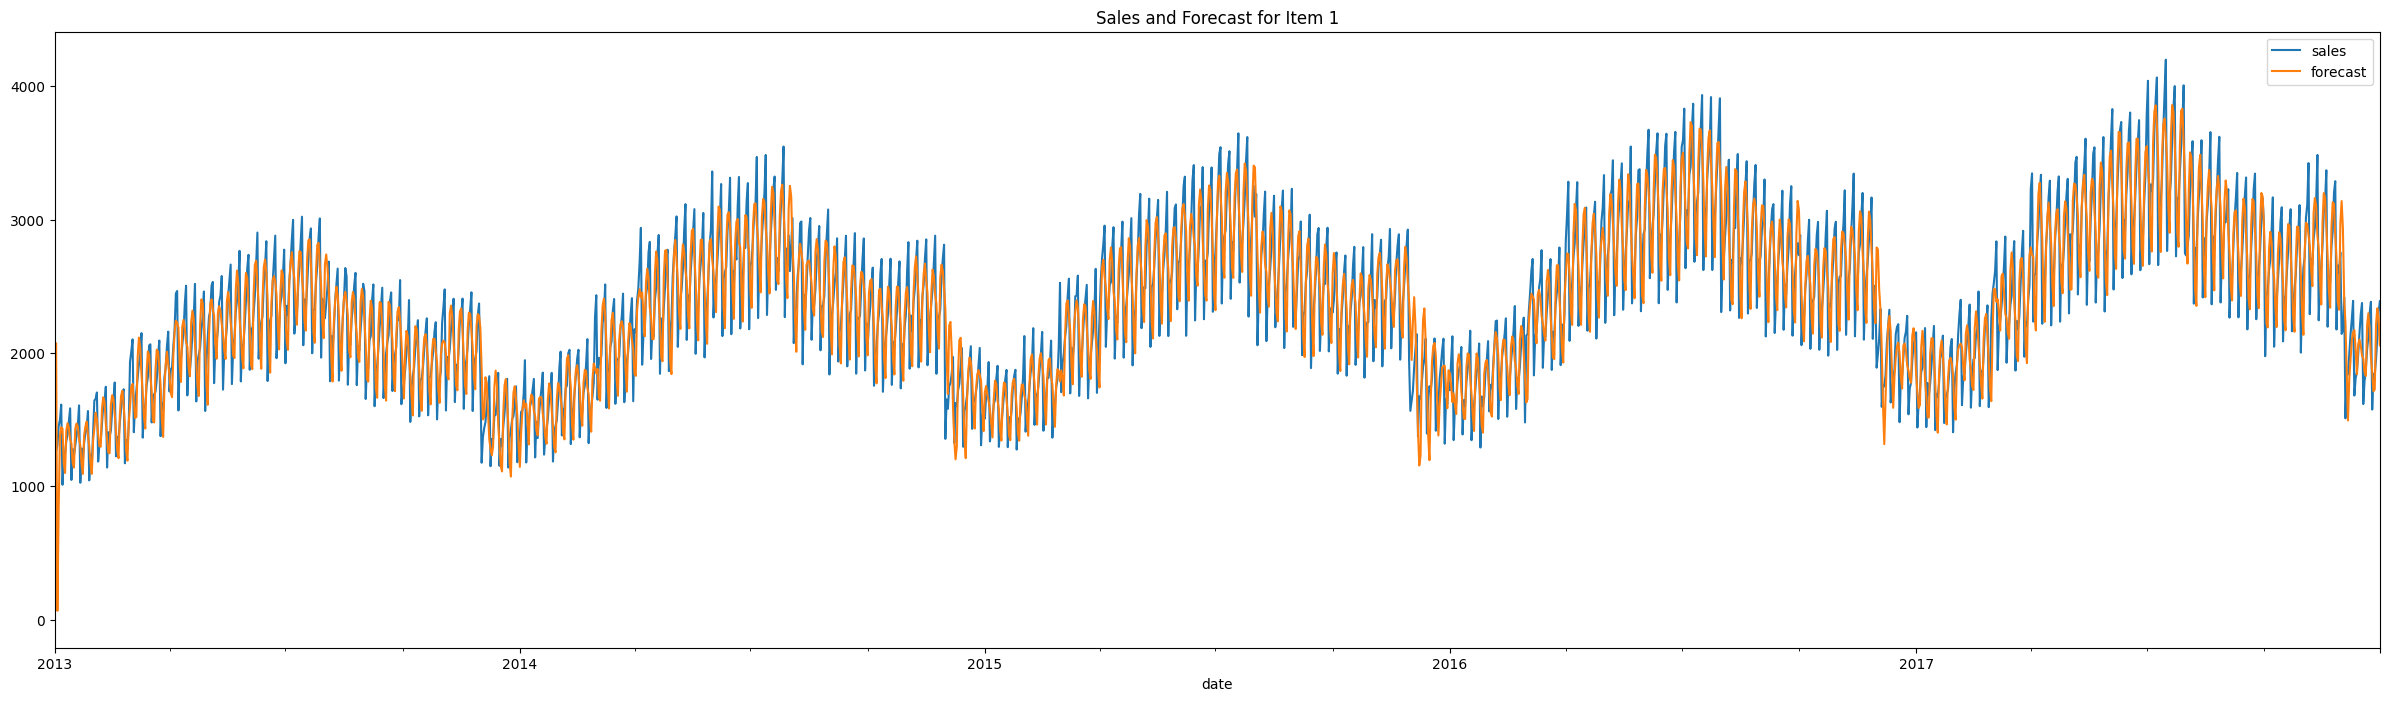

In [513]:
# sum['forecast'] = model_fit.predict(start=200, end=300, dynamic=True)
sum['forecast'] = model_fit.predict()

fig = sum[['sales', 'forecast']].plot(figsize=(30,8))
fig.set_title("Sales and Forecast for Item 1")
print('r2_Score: ', r2)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


116345.75696353595
0.6577131659954497


<Axes: xlabel='date'>

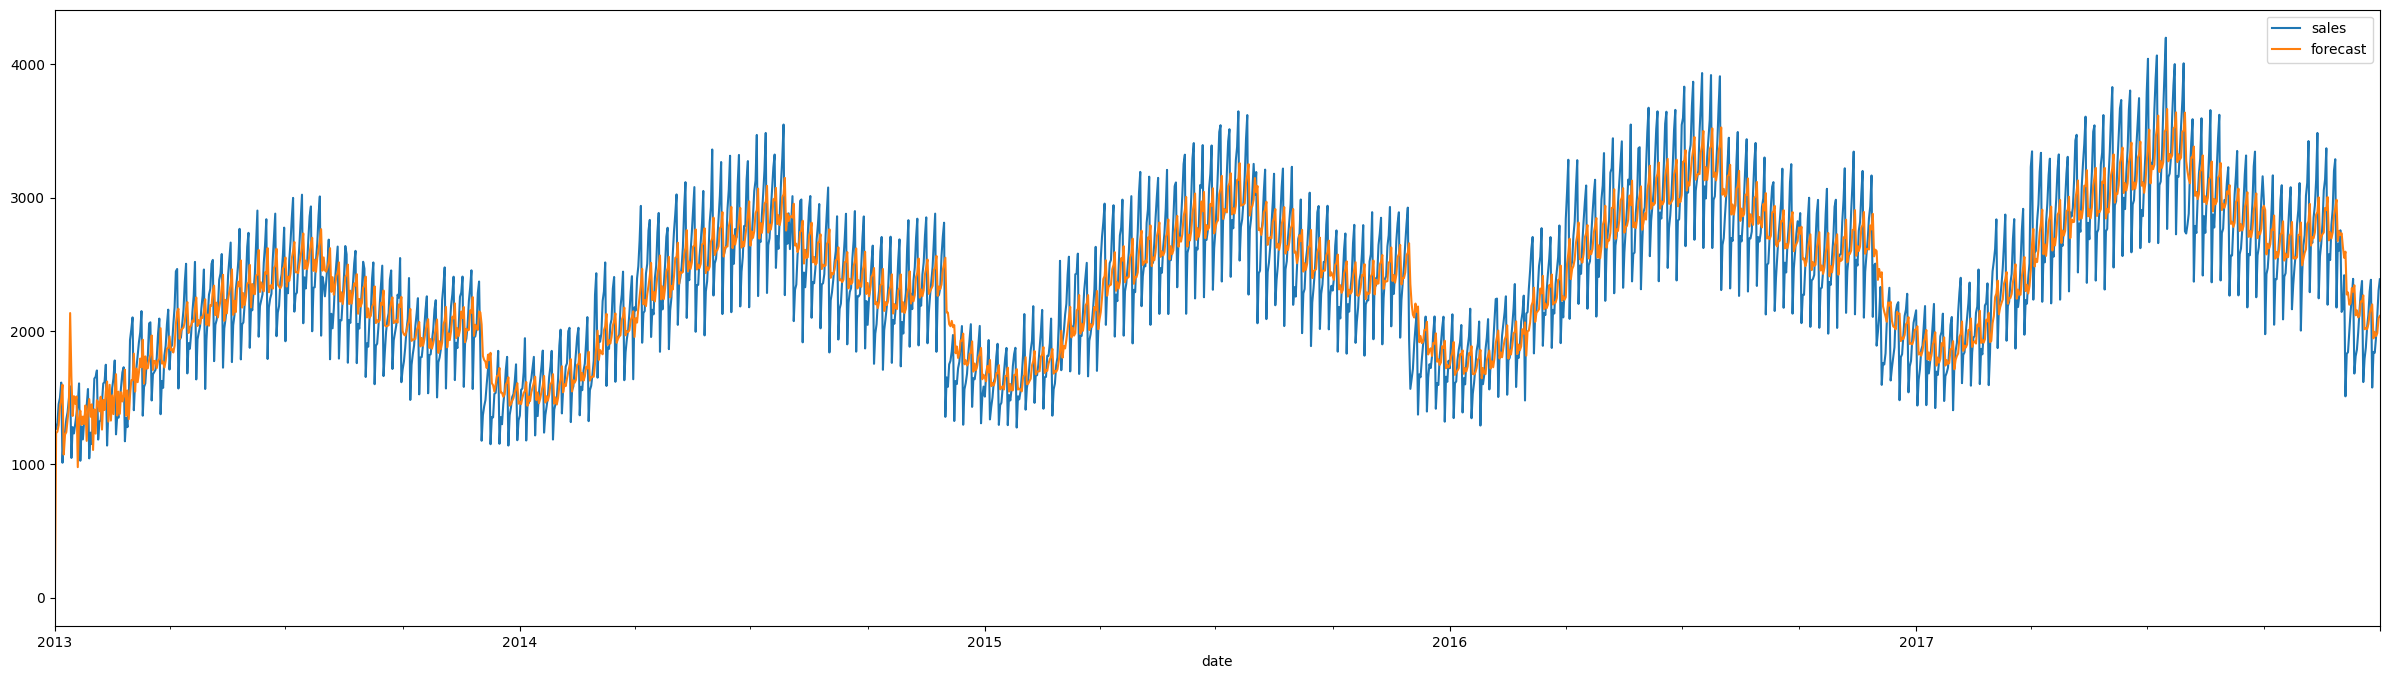

In [514]:
# Seasonal ARIMA

import statsmodels.api as sm

model=sm.tsa.statespace.SARIMAX(sum['sales'],order=(1, 1, 1),seasonal_order=(1,1,1,12))
results=model.fit()

sum['forecast'] = results.predict()

sales = sum['sales']
forecast = sum['forecast']

mse = mean_squared_error(sales, forecast)
r2 = r2_score(sales, forecast)
print(mse)
print (r2)

# sum['forecast'] = results.predict(start =500, end= 1500 )
sum[['sales', 'forecast']].plot(figsize=(30,8))

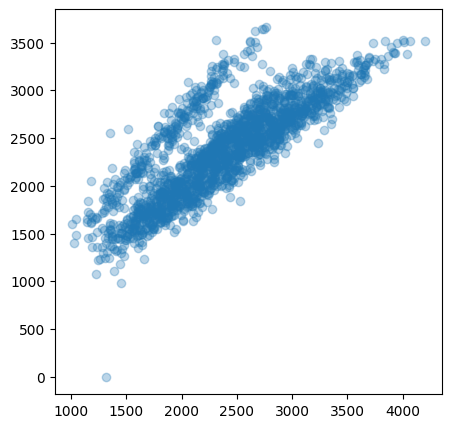

In [521]:
# Forecast plot

import numpy as np

plt.figure(figsize=(5,5))
plt.scatter(x=sum['sales'], y=sum['forecast'], alpha=0.3)

z = np.polyfit(sum['sales'], sum['forecast'], 1)
p = np.poly1d(z)

In [515]:
from pandas.tseries.offsets import DateOffset

future_dates=[sum.index[-1]+ DateOffset(months=x)for x in range(0,24)]
future_datest_df=pd.DataFrame(index=future_dates[1:],columns=sum.columns)
future_datest_df.tail()


,sales,Sale First Difference,Seasonal First Difference,forecast
2019-07-31,NaN,NaN,NaN,NaN
2019-08-31,NaN,NaN,NaN,NaN
2019-09-30,NaN,NaN,NaN,NaN
2019-10-31,NaN,NaN,NaN,NaN
2019-11-30,NaN,NaN,NaN,NaN


<Axes: >

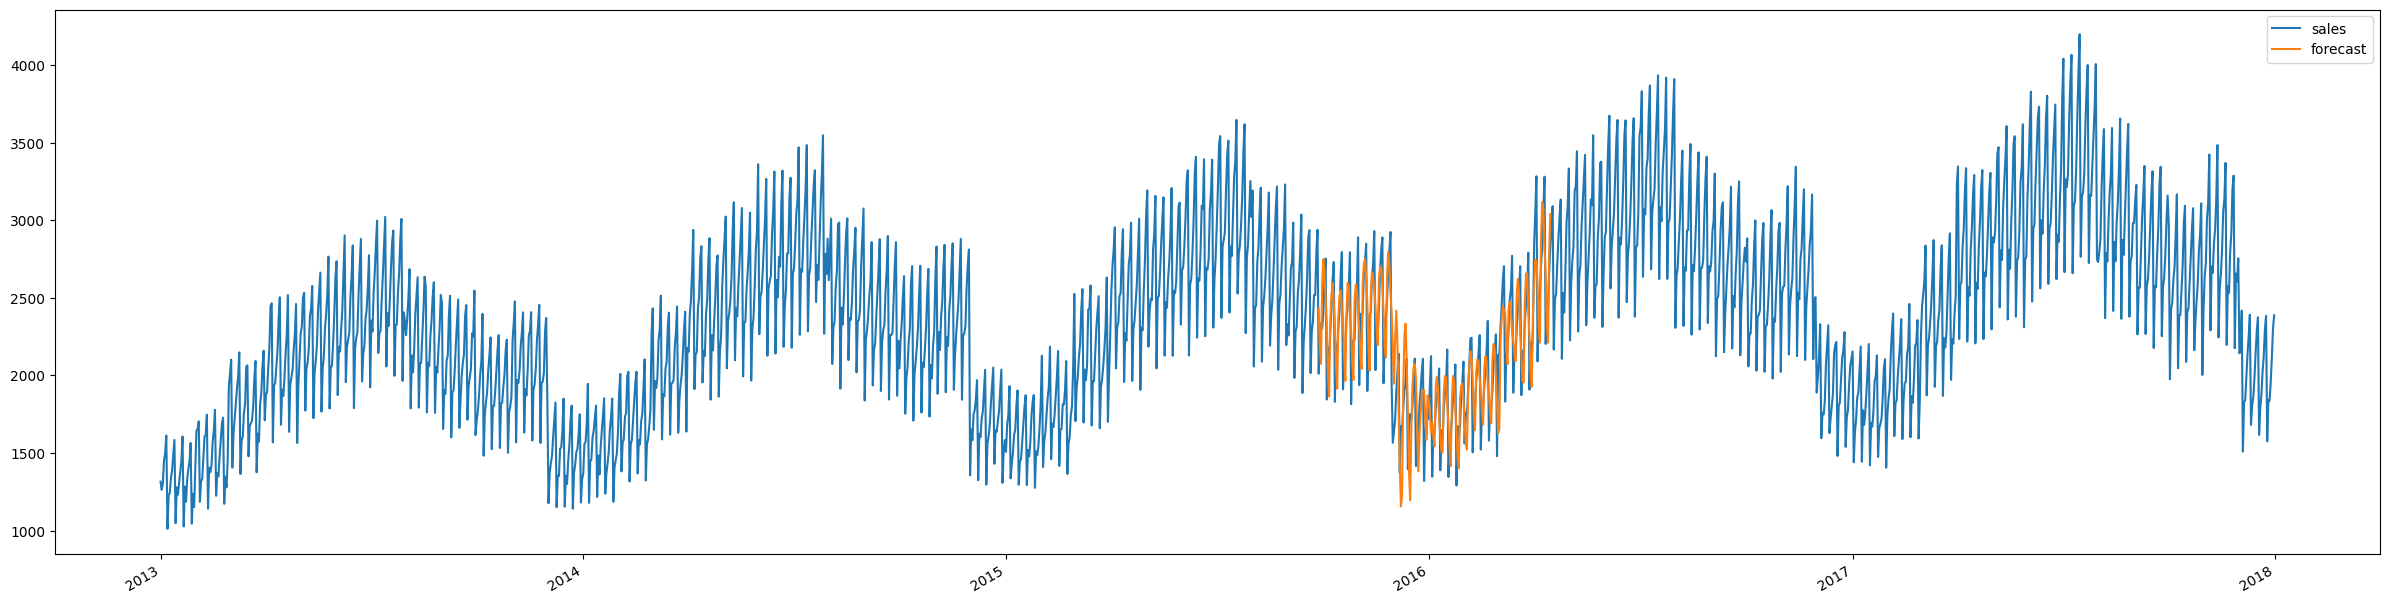

In [516]:
future_df=pd.concat([sum,future_datest_df])
future_df['forecast'] = model_fit.predict(start = 1000, end = 1200)
future_df[['sales', 'forecast']].plot(figsize=(30, 8))